<a href="https://colab.research.google.com/github/vidhan66/DCGAN-/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.datasets import CIFAR10,CelebA
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/img_align_celeba/img_align_celeba"


Mounted at /content/drive


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [4]:
class Discriminator(nn.Module):
  def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
  def forward(self, input):
        return self.main(input).view(-1, 1)

In [15]:
batch_size = 128
image_size = 64
nz = 100             # Latent vector size
lr = 0.0002
beta1 = 0.5
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "generated_images_celeba"
os.makedirs(output_dir, exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# -----------------------------
# 2. Dataset & Dataloader
# -----------------------------
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3,std= [0.5]*3)
])
from torchvision.datasets import ImageFolder
dataset = ImageFolder(root=data_path, transform=transform)

#dataset = datasets.CelebA(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -----------------------------
# 3. Initialize Models
# -----------------------------
netG = Generator().to(device)
netD = Discriminator().to(device)

# -----------------------------
# 4. Loss and Optimizer
# -----------------------------
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# -----------------------------
# 5. Fixed noise for visualization
# -----------------------------
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        b_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels
        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        ### ---- Train Discriminator ---- ###
        netD.zero_grad()

        # Real images
        output = netD(real_images).view(-1) #flatten
        lossD_real = criterion(output, real_labels)

        # Fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, fake_labels)

        # Combine and update D
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        ### ---- Train Generator ---- ###
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        lossG = criterion(output, real_labels)  # Want D to believe fakes are real
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch+1}/{epochs}] Step {i}/{len(dataloader)} "
                  f"Loss_D: {lossD.item():.4f}, Loss_G: {lossG.item():.4f}")
        torch.save(netG.state_dict(), "checkpoints/netG_latest.pth")
        torch.save(netD.state_dict(), "checkpoints/netD_latest.pth")
        torch.save(optimizerG.state_dict(), "checkpoints/optG_latest.pth")
        torch.save(optimizerD.state_dict(), "checkpoints/optD_latest.pth")
    ### ---- Save images after each epoch ---- ###
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    vutils.save_image(fake, os.path.join(output_dir, f"epoch_{epoch+1}.png"), normalize=True)

print("Training Finished!")


[1/100] Step 0/1 Loss_D: 1.7026, Loss_G: 10.2520
[2/100] Step 0/1 Loss_D: 0.7405, Loss_G: 9.6002
[3/100] Step 0/1 Loss_D: 0.0976, Loss_G: 6.0891
[4/100] Step 0/1 Loss_D: 0.1482, Loss_G: 6.9919
[5/100] Step 0/1 Loss_D: 0.0539, Loss_G: 5.5406
[6/100] Step 0/1 Loss_D: 0.0797, Loss_G: 6.1578
[7/100] Step 0/1 Loss_D: 0.0640, Loss_G: 5.9348
[8/100] Step 0/1 Loss_D: 0.0388, Loss_G: 5.6369


KeyboardInterrupt: 

In [11]:
import os
print(len(os.listdir(data_path)))  # should be number of image files


16725


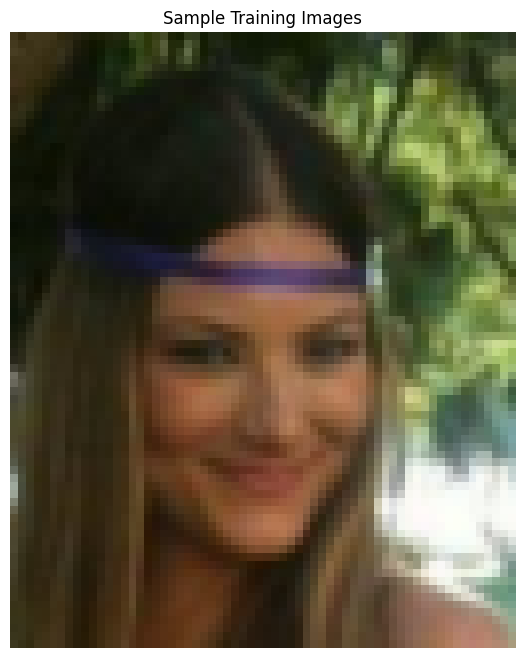

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Get a batch of real images from your DataLoader
real_batch = next(iter(dataloader))

# Show a grid of 64 images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)
plt.show()
